## watermark training

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
from PIL import Image
import pandas as pd
import random
from tqdm import tqdm
import timm

import sys
sys.path.append('../')
from watermarkmodel.model.convnext import convnext_tiny
from watermarkmodel.model.dataset import WatermarkDataset
from watermarkmodel.model.preprocess import RandomRotation
from watermarkmodel.model.train import train_model

input_size = 256

/Users/atsiri/.pyenv/versions/3.9.13/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch Version:  2.2.2
Torchvision Version:  0.17.2
PyTorch Version:  2.2.2
Torchvision Version:  0.17.2


/Users/atsiri/.pyenv/versions/3.9.13/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/Users/atsiri/.pyenv/versions/3.9.13/lib/python3.9/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


**ResNext**

In [6]:
model_ft = models.resnext50_32x4d(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

**ConvNext**

In [2]:
from watermarkmodel.model.convnext import convnext_tiny

model_ft = convnext_tiny(pretrained=True, in_22k=True, num_classes=21841)

model_ft.head = nn.Sequential( 
    nn.Linear(in_features=768, out_features=512),
    nn.GELU(),
    nn.Linear(in_features=512, out_features=256),
    nn.GELU(),
    nn.Linear(in_features=256, out_features=2),
)

**Preprocessing**

- Device Setting

In [8]:
#using cpu when gpu is not available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

- Dataset Preparation

In [2]:
from watermarkmodel.model.dataset import WatermarkDataset
import pandas as pd

#normalization
preprocess = {
    'train': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        #transforms.RandomCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        RandomRotation([90, -90], 0.2),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        #transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#read dataset
df_train = pd.read_csv('../dataset/train_data_v1.csv')
df_val = pd.read_csv('../dataset/val_data_v1.csv')

#create dataset
train_ds = WatermarkDataset(df_train, preprocess['train'])
val_ds = WatermarkDataset(df_val, preprocess['val'])
datasets = {
    'train': train_ds,
    'val': val_ds,
}

**Data Training**

In [3]:
from tqdm import tqdm
from watermarkmodel.model.train import train_model

#using cpu when gpu is not available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#model_ft = model_ft.to(device)

**training with provided data**

* pretrained_batch8_lr02e-5_epoch5

In [7]:
import warnings
warnings.filterwarnings("ignore")
from watermarkmodel.model.convnext import convnext_tiny
from watermarkmodel.model.train import train_model

model_ft = convnext_tiny(pretrained=True, in_22k=True, num_classes=21841)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#config
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(params=model_ft.parameters(), lr=0.2e-5)
BATCH_SIZE = 8
dataloaders_dict = {
    x: torch.utils.data.DataLoader(datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=0) #to prevent runtimeerror on non gpu device
    for x in ['train', 'val']
}

#train
model_ft.head = nn.Sequential( 
    nn.Linear(in_features=768, out_features=512),
    nn.GELU(),
    nn.Linear(in_features=512, out_features=256),
    nn.GELU(),
    nn.Linear(in_features=256, out_features=2),
)

model_ft, train_acc_history, val_acc_history = train_model(
    model_ft, dataloaders_dict, criterion, optimizer, num_epochs=10
)

Epoch 0/9
----------


100%|██████████| 14/14 [00:46<00:00,  3.35s/it]


train Loss: 0.6876 Acc: 0.5982


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


val Loss: 0.6839 Acc: 0.6429

Epoch 1/9
----------


100%|██████████| 14/14 [00:44<00:00,  3.17s/it]


train Loss: 0.6811 Acc: 0.7054


100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


val Loss: 0.6812 Acc: 0.6429

Epoch 2/9
----------


100%|██████████| 14/14 [00:45<00:00,  3.22s/it]


train Loss: 0.6756 Acc: 0.7143


100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


val Loss: 0.6784 Acc: 0.6429

Epoch 3/9
----------


100%|██████████| 14/14 [00:44<00:00,  3.18s/it]


train Loss: 0.6697 Acc: 0.7232


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


val Loss: 0.6753 Acc: 0.6429

Epoch 4/9
----------


100%|██████████| 14/14 [00:46<00:00,  3.31s/it]


train Loss: 0.6636 Acc: 0.7232


100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


val Loss: 0.6730 Acc: 0.6429

Epoch 5/9
----------


100%|██████████| 14/14 [00:44<00:00,  3.21s/it]


train Loss: 0.6586 Acc: 0.7232


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


val Loss: 0.6701 Acc: 0.6429

Epoch 6/9
----------


100%|██████████| 14/14 [00:45<00:00,  3.23s/it]


train Loss: 0.6496 Acc: 0.7232


100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


val Loss: 0.6671 Acc: 0.6429

Epoch 7/9
----------


100%|██████████| 14/14 [00:45<00:00,  3.23s/it]


train Loss: 0.6443 Acc: 0.7232


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


val Loss: 0.6646 Acc: 0.6429

Epoch 8/9
----------


100%|██████████| 14/14 [00:45<00:00,  3.26s/it]


train Loss: 0.6371 Acc: 0.7232


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


val Loss: 0.6616 Acc: 0.6429

Epoch 9/9
----------


100%|██████████| 14/14 [00:44<00:00,  3.19s/it]


train Loss: 0.6310 Acc: 0.7232


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]

val Loss: 0.6588 Acc: 0.6429

Training complete in 7m 46s
Best val Acc: 0.642857


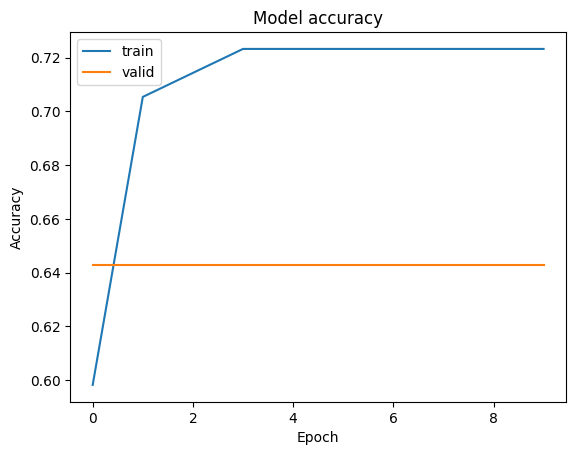

In [8]:
torch.save(model_ft.state_dict(), '../watermarkmodel/model/weights/convnext-tiny_watermarks_detector_datav1_batch8_lr02e-5_.pth')
plt.plot([i.cpu().item() for i in train_acc_history])
plt.plot([i.cpu().item() for i in val_acc_history])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

* pretrained_batch16_lr02e-5_epoch5

In [9]:
import warnings
warnings.filterwarnings("ignore")
from watermarkmodel.model.convnext import convnext_tiny

model_ft = convnext_tiny(pretrained=True, in_22k=True, num_classes=21841)

#config
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(params=model_ft.parameters(), lr=0.2e-5)
BATCH_SIZE = 16
dataloaders_dict = {
    x: torch.utils.data.DataLoader(datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=0) #to prevent runtimeerror on non gpu device
    for x in ['train', 'val']
    }

#train
model_ft.head = nn.Sequential( 
    nn.Linear(in_features=768, out_features=512),
    nn.GELU(),
    nn.Linear(in_features=512, out_features=256),
    nn.GELU(),
    nn.Linear(in_features=256, out_features=2),
)

model_ft, train_acc_history, val_acc_history = train_model(
    model_ft, dataloaders_dict, criterion, optimizer, num_epochs=10
)

Epoch 0/9
----------


100%|██████████| 7/7 [00:44<00:00,  6.31s/it]


train Loss: 0.6850 Acc: 0.6339


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val Loss: 0.6820 Acc: 0.6429

Epoch 1/9
----------


100%|██████████| 7/7 [00:41<00:00,  5.90s/it]


train Loss: 0.6801 Acc: 0.7143


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val Loss: 0.6801 Acc: 0.6429

Epoch 2/9
----------


100%|██████████| 7/7 [00:41<00:00,  5.96s/it]


train Loss: 0.6775 Acc: 0.7232


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val Loss: 0.6781 Acc: 0.6429

Epoch 3/9
----------


100%|██████████| 7/7 [00:41<00:00,  5.94s/it]


train Loss: 0.6749 Acc: 0.7411


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


val Loss: 0.6761 Acc: 0.6429

Epoch 4/9
----------


100%|██████████| 7/7 [00:43<00:00,  6.23s/it]


train Loss: 0.6698 Acc: 0.7321


100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


val Loss: 0.6743 Acc: 0.6429

Epoch 5/9
----------


100%|██████████| 7/7 [00:45<00:00,  6.50s/it]


train Loss: 0.6684 Acc: 0.7232


100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


val Loss: 0.6725 Acc: 0.6429

Epoch 6/9
----------


100%|██████████| 7/7 [00:43<00:00,  6.23s/it]


train Loss: 0.6661 Acc: 0.7232


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


val Loss: 0.6706 Acc: 0.6429

Epoch 7/9
----------


100%|██████████| 7/7 [00:42<00:00,  6.11s/it]


train Loss: 0.6616 Acc: 0.7232


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


val Loss: 0.6688 Acc: 0.6429

Epoch 8/9
----------


100%|██████████| 7/7 [00:43<00:00,  6.22s/it]


train Loss: 0.6578 Acc: 0.7232


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val Loss: 0.6671 Acc: 0.6429

Epoch 9/9
----------


100%|██████████| 7/7 [00:45<00:00,  6.48s/it]


train Loss: 0.6549 Acc: 0.7232


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

val Loss: 0.6654 Acc: 0.6429

Training complete in 7m 26s
Best val Acc: 0.642857


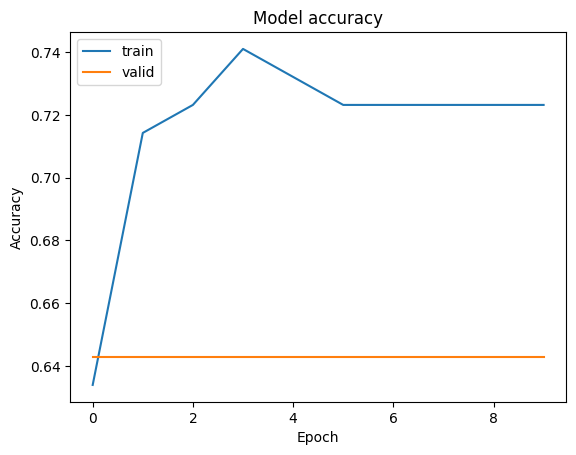

In [10]:
torch.save(model_ft.state_dict(), '../watermarkmodel/model/weights/convnext-tiny_watermarks_detector_datav1_batch16_lr02e-5_epoch5.pth')
plt.plot([i.cpu().item() for i in train_acc_history])
plt.plot([i.cpu().item() for i in val_acc_history])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

* pretrained_batch32_lr02e-5_epoch5

In [11]:
import warnings
warnings.filterwarnings("ignore")
from watermarkmodel.model.convnext import convnext_tiny

model_ft = convnext_tiny(pretrained=True, in_22k=True, num_classes=21841)

#config
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(params=model_ft.parameters(), lr=0.2e-5)
BATCH_SIZE = 32
dataloaders_dict = {
    x: torch.utils.data.DataLoader(datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=0) #to prevent runtimeerror on non gpu device
    for x in ['train', 'val']
    }

#train
model_ft.head = nn.Sequential( 
    nn.Linear(in_features=768, out_features=512),
    nn.GELU(),
    nn.Linear(in_features=512, out_features=256),
    nn.GELU(),
    nn.Linear(in_features=256, out_features=2),
)

model_ft, train_acc_history, val_acc_history = train_model(
    model_ft, dataloaders_dict, criterion, optimizer, num_epochs=10
)

Epoch 0/9
----------


100%|██████████| 4/4 [01:35<00:00, 23.79s/it]


train Loss: 0.7055 Acc: 0.2589


100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


val Loss: 0.7039 Acc: 0.2143

Epoch 1/9
----------


100%|██████████| 4/4 [01:23<00:00, 20.83s/it]


train Loss: 0.7033 Acc: 0.2946


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


val Loss: 0.7025 Acc: 0.2857

Epoch 2/9
----------


100%|██████████| 4/4 [01:32<00:00, 23.22s/it]


train Loss: 0.7010 Acc: 0.3214


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


val Loss: 0.7010 Acc: 0.2857

Epoch 3/9
----------


100%|██████████| 4/4 [01:32<00:00, 23.24s/it]


train Loss: 0.6980 Acc: 0.4554


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


val Loss: 0.6995 Acc: 0.5000

Epoch 4/9
----------


100%|██████████| 4/4 [01:20<00:00, 20.04s/it]


train Loss: 0.6952 Acc: 0.5000


100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


val Loss: 0.6980 Acc: 0.5000

Epoch 5/9
----------


100%|██████████| 4/4 [01:17<00:00, 19.27s/it]


train Loss: 0.6941 Acc: 0.4821


100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


val Loss: 0.6966 Acc: 0.5714

Epoch 6/9
----------


100%|██████████| 4/4 [01:32<00:00, 23.24s/it]


train Loss: 0.6901 Acc: 0.5714


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


val Loss: 0.6953 Acc: 0.5714

Epoch 7/9
----------


100%|██████████| 4/4 [01:20<00:00, 20.13s/it]


train Loss: 0.6876 Acc: 0.6071


100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


val Loss: 0.6940 Acc: 0.6429

Epoch 8/9
----------


100%|██████████| 4/4 [01:21<00:00, 20.44s/it]


train Loss: 0.6865 Acc: 0.6250


100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


val Loss: 0.6927 Acc: 0.5714

Epoch 9/9
----------


100%|██████████| 4/4 [01:18<00:00, 19.68s/it]


train Loss: 0.6843 Acc: 0.6607


100%|██████████| 1/1 [00:01<00:00,  1.65s/it]

val Loss: 0.6915 Acc: 0.5714

Training complete in 14m 34s
Best val Acc: 0.642857


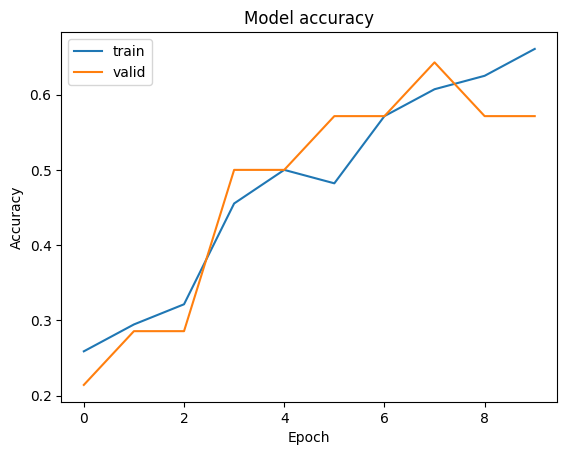

In [13]:
torch.save(model_ft.state_dict(), '../watermarkmodel/model/weights/convnext-tiny_watermarks_detector_datav1_batch32_lr02e-5_epoch5.pth')
plt.plot([i.cpu().item() for i in train_acc_history])
plt.plot([i.cpu().item() for i in val_acc_history])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

* pretrained_batch8_lr01e-3_epoch5

In [4]:
import warnings
warnings.filterwarnings("ignore")
from watermarkmodel.model.convnext import convnext_tiny

model_ft = convnext_tiny(pretrained=True, in_22k=True, num_classes=21841)

#config
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(params=model_ft.parameters(), lr=0.1e-3)
BATCH_SIZE = 8
dataloaders_dict = {
    x: torch.utils.data.DataLoader(datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=0) #to prevent runtimeerror on non gpu device
    for x in ['train', 'val']
    }

#train
model_ft.head = nn.Sequential( 
    nn.Linear(in_features=768, out_features=512),
    nn.GELU(),
    nn.Linear(in_features=512, out_features=256),
    nn.GELU(),
    nn.Linear(in_features=256, out_features=2),
)

model_ft, train_acc_history, val_acc_history = train_model(
    model_ft, dataloaders_dict, criterion, optimizer, num_epochs=10
)

Epoch 0/9
----------


100%|██████████| 14/14 [00:48<00:00,  3.48s/it]


train Loss: 0.6012 Acc: 0.7232


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


val Loss: 0.5547 Acc: 0.6429

Epoch 1/9
----------


100%|██████████| 14/14 [00:46<00:00,  3.34s/it]


train Loss: 0.4228 Acc: 0.7232


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


val Loss: 0.3623 Acc: 0.7857

Epoch 2/9
----------


100%|██████████| 14/14 [00:45<00:00,  3.26s/it]


train Loss: 0.3186 Acc: 0.9286


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


val Loss: 0.6050 Acc: 0.7857

Epoch 3/9
----------


100%|██████████| 14/14 [00:45<00:00,  3.24s/it]


train Loss: 0.2610 Acc: 0.9554


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


val Loss: 0.2073 Acc: 1.0000

Epoch 4/9
----------


100%|██████████| 14/14 [00:46<00:00,  3.31s/it]


train Loss: 0.2155 Acc: 0.9464


100%|██████████| 2/2 [00:01<00:00,  1.38it/s]


val Loss: 0.1645 Acc: 1.0000

Epoch 5/9
----------


100%|██████████| 14/14 [00:45<00:00,  3.24s/it]


train Loss: 0.1588 Acc: 0.9732


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


val Loss: 0.1329 Acc: 1.0000

Epoch 6/9
----------


100%|██████████| 14/14 [00:50<00:00,  3.62s/it]


train Loss: 0.1456 Acc: 0.9911


100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


val Loss: 0.3403 Acc: 0.9286

Epoch 7/9
----------


100%|██████████| 14/14 [00:46<00:00,  3.30s/it]


train Loss: 0.1029 Acc: 0.9911


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


val Loss: 0.1056 Acc: 1.0000

Epoch 8/9
----------


100%|██████████| 14/14 [00:48<00:00,  3.46s/it]


train Loss: 0.1095 Acc: 0.9821


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


val Loss: 0.2156 Acc: 0.9286

Epoch 9/9
----------


100%|██████████| 14/14 [00:47<00:00,  3.42s/it]


train Loss: 0.0871 Acc: 0.9911


100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

val Loss: 0.1182 Acc: 1.0000

Training complete in 8m 6s
Best val Acc: 1.000000


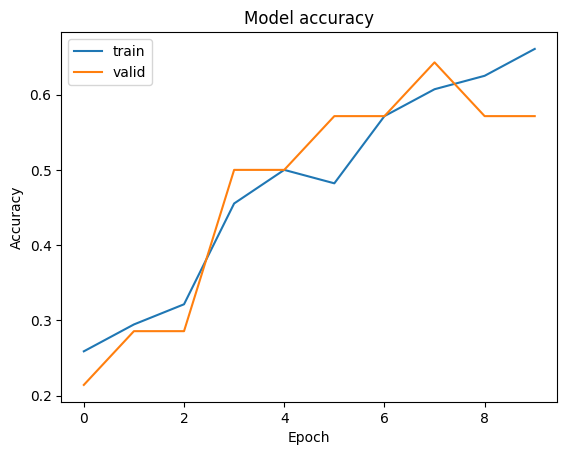

In [12]:
torch.save(model_ft.state_dict(), '../watermarkmodel/model/weights/convnext-tiny_watermarks_detector_datav1_batch8_lr01e-3_epoch5.pth')
plt.plot([i.cpu().item() for i in train_acc_history])
plt.plot([i.cpu().item() for i in val_acc_history])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

* pretrained_batch16_lr01e-3_epoch5

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from watermarkmodel.model.convnext import convnext_tiny

model_ft = convnext_tiny(pretrained=True, in_22k=True, num_classes=21841)

#config
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(params=model_ft.parameters(), lr=0.1e-3)
BATCH_SIZE = 16
dataloaders_dict = {
    x: torch.utils.data.DataLoader(datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=0) #to prevent runtimeerror on non gpu device
    for x in ['train', 'val']
    }

#train
model_ft.head = nn.Sequential( 
    nn.Linear(in_features=768, out_features=512),
    nn.GELU(),
    nn.Linear(in_features=512, out_features=256),
    nn.GELU(),
    nn.Linear(in_features=256, out_features=2),
)

model_ft, train_acc_history, val_acc_history = train_model(
    model_ft, dataloaders_dict, criterion, optimizer, num_epochs=10
)

Epoch 0/4
----------


100%|██████████| 7/7 [01:16<00:00, 10.98s/it]


train Loss: 0.6260 Acc: 0.7143


100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


val Loss: 0.6445 Acc: 0.6429

Epoch 1/4
----------


100%|██████████| 7/7 [01:03<00:00,  9.11s/it]


train Loss: 0.5584 Acc: 0.7232


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


val Loss: 0.6208 Acc: 0.6429

Epoch 2/4
----------


100%|██████████| 7/7 [01:23<00:00, 11.96s/it]


train Loss: 0.4671 Acc: 0.7232


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


val Loss: 0.4854 Acc: 0.6429

Epoch 3/4
----------


100%|██████████| 7/7 [01:13<00:00, 10.53s/it]


train Loss: 0.3782 Acc: 0.7321


100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


val Loss: 0.3642 Acc: 0.7143

Epoch 4/4
----------


100%|██████████| 7/7 [01:25<00:00, 12.20s/it]


train Loss: 0.3076 Acc: 0.9196


100%|██████████| 1/1 [00:01<00:00,  1.70s/it]

val Loss: 0.3022 Acc: 0.8571

Training complete in 6m 33s
Best val Acc: 0.857143


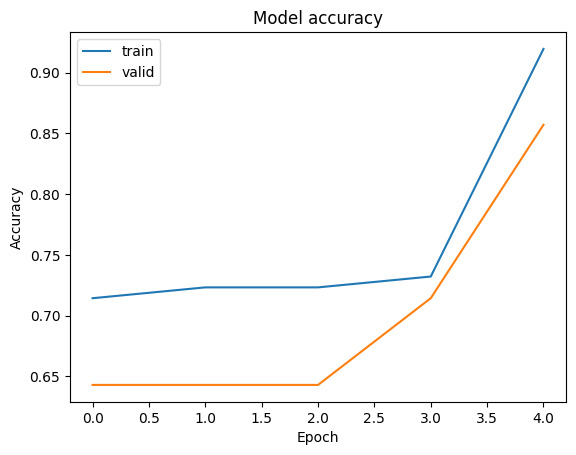

In [ ]:
torch.save(model_ft.state_dict(), '../watermarkmodel/model/weights/convnext-tiny_watermarks_detector_datav1_batch16_lr01e-3_epoch5.pth')
plt.plot([i.cpu().item() for i in train_acc_history])
plt.plot([i.cpu().item() for i in val_acc_history])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

* pretrained_batch32_lr01e-3_epoch5

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from watermarkmodel.model.convnext import convnext_tiny

model_ft = convnext_tiny(pretrained=True, in_22k=True, num_classes=21841)

#config
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(params=model_ft.parameters(), lr=0.1e-3)
BATCH_SIZE = 32
dataloaders_dict = {
    x: torch.utils.data.DataLoader(datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=0) #to prevent runtimeerror on non gpu device
    for x in ['train', 'val']
    }

#train
model_ft.head = nn.Sequential( 
    nn.Linear(in_features=768, out_features=512),
    nn.GELU(),
    nn.Linear(in_features=512, out_features=256),
    nn.GELU(),
    nn.Linear(in_features=256, out_features=2),
)

model_ft, train_acc_history, val_acc_history = train_model(
    model_ft, dataloaders_dict, criterion, optimizer, num_epochs=10
)

Epoch 0/4
----------


100%|██████████| 4/4 [01:19<00:00, 19.99s/it]


train Loss: 0.6455 Acc: 0.7232


100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


val Loss: 0.6391 Acc: 0.6429

Epoch 1/4
----------


100%|██████████| 4/4 [02:02<00:00, 30.56s/it]


train Loss: 0.5579 Acc: 0.7232


100%|██████████| 1/1 [00:03<00:00,  3.49s/it]


val Loss: 0.5934 Acc: 0.6429

Epoch 2/4
----------


100%|██████████| 4/4 [02:13<00:00, 33.26s/it]


train Loss: 0.4790 Acc: 0.7232


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


val Loss: 0.5162 Acc: 0.6429

Epoch 3/4
----------


100%|██████████| 4/4 [01:55<00:00, 28.97s/it]


train Loss: 0.4016 Acc: 0.7232


100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


val Loss: 0.4375 Acc: 0.6429

Epoch 4/4
----------


100%|██████████| 4/4 [01:49<00:00, 27.42s/it]


train Loss: 0.3442 Acc: 0.7232


100%|██████████| 1/1 [00:03<00:00,  3.67s/it]

val Loss: 0.3669 Acc: 0.6429

Training complete in 9m 34s
Best val Acc: 0.642857


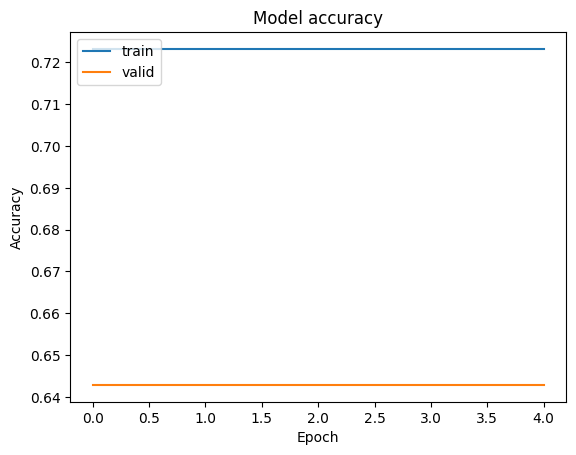

In [ ]:
torch.save(model_ft.state_dict(), '../watermarkmodel/model/weights/convnext-tiny_watermarks_detector_datav1_batch32_lr01e-3_epoch5.pth')
plt.plot([i.cpu().item() for i in train_acc_history])
plt.plot([i.cpu().item() for i in val_acc_history])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
#os.makedirs('../watermarkmodel/model/weights', exist_ok=True)
torch.save(model_ft.state_dict(), '../watermarkmodel/model/weights/convnext-tiny_watermarks_detector_datav1_batch16_lr01e-3_epoch5_.pth')
#"../watermarkmodel/model/weights/convnext-notpretrained-t_3layer-head_inp256_datasetv1_10epochs.pth")

**training with untrained convnext**

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from watermarkmodel.model.convnext import convnext_tiny

model_ft = convnext_tiny(pretrained=False, in_22k=True, num_classes=21841)

#config
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(params=model_ft.parameters(), lr=0.1e-3)
BATCH_SIZE = 16
dataloaders_dict = {
    x: torch.utils.data.DataLoader(datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=0) #to prevent runtimeerror on non gpu device
    for x in ['train', 'val']
    }

model_ft.head = nn.Sequential( 
    nn.Linear(in_features=768, out_features=512),
    nn.GELU(),
    nn.Linear(in_features=512, out_features=256),
    nn.GELU(),
    nn.Linear(in_features=256, out_features=2),
)

model_ft, train_acc_history, val_acc_history = train_model(
    model_ft, dataloaders_dict, criterion, optimizer, num_epochs=10
)

Epoch 0/4
----------


100%|██████████| 7/7 [01:18<00:00, 11.19s/it]


train Loss: 0.6265 Acc: 0.6071


100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


val Loss: 0.6402 Acc: 0.5714

Epoch 1/4
----------


100%|██████████| 7/7 [01:06<00:00,  9.54s/it]


train Loss: 0.5877 Acc: 0.7232


100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


val Loss: 0.6490 Acc: 0.5714

Epoch 2/4
----------


100%|██████████| 7/7 [00:57<00:00,  8.21s/it]


train Loss: 0.5707 Acc: 0.7321


100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


val Loss: 0.6605 Acc: 0.5714

Epoch 3/4
----------


100%|██████████| 7/7 [00:52<00:00,  7.51s/it]


train Loss: 0.5621 Acc: 0.7321


100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


val Loss: 0.6604 Acc: 0.5714

Epoch 4/4
----------


100%|██████████| 7/7 [00:50<00:00,  7.26s/it]


train Loss: 0.5443 Acc: 0.7411


100%|██████████| 1/1 [00:01<00:00,  1.53s/it]

val Loss: 0.6804 Acc: 0.5714

Training complete in 5m 14s
Best val Acc: 0.571429


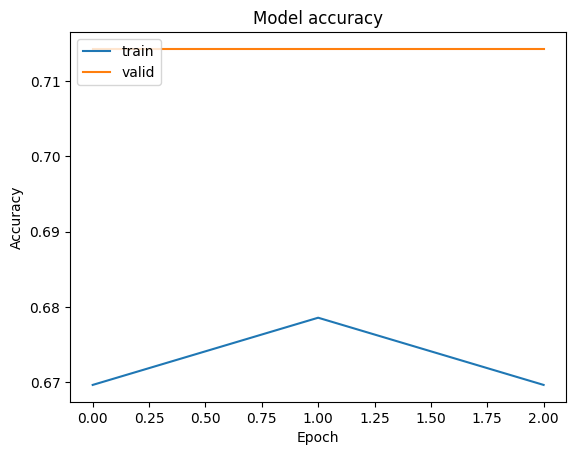

In [ ]:
plt.plot([i.cpu().item() for i in train_acc_history])
plt.plot([i.cpu().item() for i in val_acc_history])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
torch.save(model_ft.state_dict(), '../watermarkmodel/model/weights/convnext-tiny_watermarks_detector_data_v1_untrained.pth')
plt.show()

**training with resnet model**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

model_ft = models.resnext50_32x4d(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft, train_acc_history, val_acc_history = train_model(
    model_ft, dataloaders_dict, criterion, optimizer, num_epochs=10
)

Epoch 0/9
----------


100%|██████████| 2/2 [02:05<00:00, 62.54s/it]


train Loss: 0.6809 Acc: 0.6071


100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


val Loss: 0.6360 Acc: 0.6429

Epoch 1/9
----------


100%|██████████| 2/2 [01:41<00:00, 50.56s/it]


train Loss: 0.6696 Acc: 0.5625


100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


val Loss: 0.6361 Acc: 0.6429

Epoch 2/9
----------


100%|██████████| 2/2 [01:38<00:00, 49.30s/it]


train Loss: 0.6850 Acc: 0.5893


100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


val Loss: 0.6360 Acc: 0.6429

Epoch 3/9
----------


100%|██████████| 2/2 [01:28<00:00, 44.26s/it]


train Loss: 0.6719 Acc: 0.5804


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


val Loss: 0.6370 Acc: 0.6429

Epoch 4/9
----------


100%|██████████| 2/2 [01:30<00:00, 45.15s/it]


train Loss: 0.6704 Acc: 0.6071


100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


val Loss: 0.6400 Acc: 0.6429

Epoch 5/9
----------


100%|██████████| 2/2 [01:43<00:00, 51.89s/it]


train Loss: 0.6736 Acc: 0.6518


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


val Loss: 0.6442 Acc: 0.6429

Epoch 6/9
----------


100%|██████████| 2/2 [52:46<00:00, 1583.49s/it]


train Loss: 0.6750 Acc: 0.6339


100%|██████████| 1/1 [00:10<00:00, 10.52s/it]


val Loss: 0.6472 Acc: 0.7143

Epoch 7/9
----------


100%|██████████| 2/2 [03:10<00:00, 95.10s/it] 


train Loss: 0.6788 Acc: 0.5536


100%|██████████| 1/1 [00:02<00:00,  2.72s/it]


val Loss: 0.6497 Acc: 0.7143

Epoch 8/9
----------


100%|██████████| 2/2 [33:15<00:00, 997.76s/it] 


train Loss: 0.6735 Acc: 0.5446


100%|██████████| 1/1 [00:03<00:00,  3.43s/it]


val Loss: 0.6507 Acc: 0.7143

Epoch 9/9
----------


100%|██████████| 2/2 [02:17<00:00, 68.80s/it]


train Loss: 0.6638 Acc: 0.6518


100%|██████████| 1/1 [00:03<00:00,  3.14s/it]

val Loss: 0.6535 Acc: 0.7143

Training complete in 102m 10s
Best val Acc: 0.714286


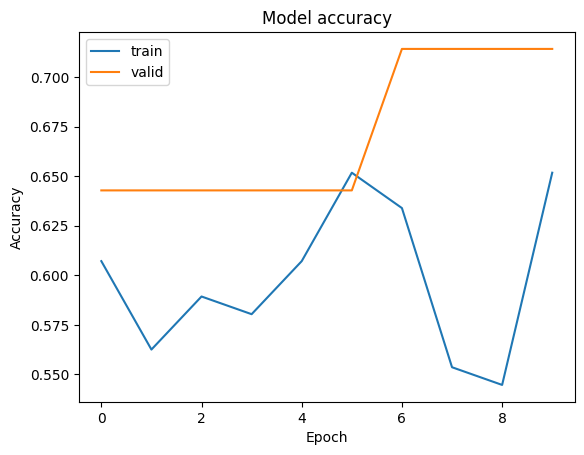

In [ ]:
plt.plot([i.cpu().item() for i in train_acc_history])
plt.plot([i.cpu().item() for i in val_acc_history])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
os.makedirs('../watermarkmodel/model/weights', exist_ok=True)
torch.save(model_ft.state_dict(), "../weights/resnext-t_3layer-head_inp256_datasetv1-1_10epochs_v3.pth")

## create model pickle from the best result **(pretrained_batch8_lr01e-3_epoch5)**

In [ ]:
import pickle

#save model
filename = 'watermark_model.pkl'
pickle.dump(model_ft, open(filename, 'wb'))
print('done')

done


## model evaluation

**(pretrained_batch8_lr01e-3_epoch10)**

In [29]:
import warnings
warnings.filterwarnings("ignore")
from PIL import Image
from watermarkmodel.utils import list_images
from watermarkmodel.model import get_convnext_model
from watermarkmodel.model.predictor import WatermarksPredictor
import pandas as pd
import pickle

#validation data
images = list_images('../images/test_images/') 

pkl_filename = "watermark_model.pkl"
with open(pkl_filename, 'rb') as f_in:
    modelpkl = pickle.load(f_in)

transforms = get_convnext_model('convnext-tiny')[1]
predictor = WatermarksPredictor(modelpkl, transforms, 'cpu')
result = predictor.run(images)
result

  0%|          | 0/2 [00:00<?, ?it/s]/Users/atsiri/.pyenv/versions/3.9.13/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/Users/atsiri/.pyenv/versions/3.9.13/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/Users/atsiri/.pyenv/versions/3.9.13/lib/python3.9/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/Users/atsiri/.pyenv/versions/3.9.13/lib/python3.9/site-packages/timm

[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1]

In [30]:
df_testcsv = pd.read_csv('../dataset/test_data_v1.csv')
df_testcsv['filename'] = df_testcsv['path'].apply(os.path.basename)

df_testresult = pd.DataFrame(list(zip(images, result)), columns=['path', 'prediction'])
df_testresult['filename'] = df_testresult['path'].apply(os.path.basename)

df_result = df_testcsv.merge(df_testresult, left_on='filename', right_on='filename')[['filename', 'label', 'prediction']]
accuracy = df_result[df_result.label == df_result.prediction]['filename'].count() / len(df_result) * 100
print('accuracy :', accuracy, '%') 

#rename label
df_result

accuracy : 92.3076923076923 %


,filename,label,prediction
0,bZLiwU5tEpXCZ6af.jpg,0,0
1,ZgBqRHo3EIwBE5Sx.jpg,0,0
2,GSdGPBGUpDlHtFB3.jpg,0,0
3,fOZiLOQwSxZdxwRl.jpg,1,1
4,8rTYBEpXxadDIsqN.jpg,0,0
5,zaSr0PPy8Ozb5j91.jpg,0,0
6,Szndo6wJr7r6c142.jpg,0,0
7,X8rMOlzQ5VhObWBA.jpg,0,0
8,635Jvu8SQ7hfRVb9.jpg,1,0
9,cLAoxiZ092kU74de.jpg,1,1


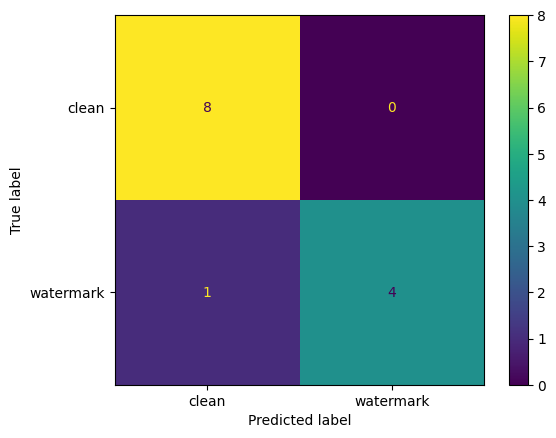

In [36]:
from watermarkmodel.model.metrics import plot_confusion_matrix

plot_confusion_matrix(df_result['label'].values, df_result['prediction'].values).figure_.savefig('confusion_matrix.png')